# Notebook 1: Black-Scholes-Merton Pricing and Greeks

This notebook explores option pricing using the Black-Scholes-Merton (BSM) model and the sensitivity measures known as "Greeks."

## Learning Objectives:
- Understand BSM pricing for European calls and puts
- Visualize payoff and P&L diagrams
- Compute and interpret all five Greeks (Delta, Gamma, Vega, Theta, Rho)
- Explore how Greeks vary with stock price (moneyness) and time to expiration (DTE)
- Understand the practical meaning of each Greek for risk management


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../src')

from options_toolkit.bsm import (
    bsm_call_price,
    bsm_put_price,
    bsm_call_greeks,
    bsm_put_greeks,
    implied_volatility
)
from options_toolkit.payoffs import call_pnl, put_pnl, straddle_pnl
from options_toolkit.monte_carlo import (
    simulate_gbm_paths,
    monte_carlo_price,
    mc_delta,
    mc_vega
)
from options_toolkit.strategies import (
    long_straddle_analysis,
    delta_hedge_illustration,
    vega_hedge_illustration
)
from options_toolkit.viz import (
    plot_payoff_diagram,
    plot_greeks_vs_spot,
    plot_straddle_payoff,
    plot_delta_hedge_comparison
)

from ipywidgets import interact, FloatSlider, IntSlider, Dropdown

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

print("✅ All imports loaded! Interactive widgets ready.")


✅ All imports loaded! Interactive widgets ready.


## 1. Basic Option Pricing

Let's price a call and put option with the following parameters:
- Current stock price S = $100
- Strike price K = $100 (at-the-money)
- Risk-free rate r = 5% (annualized)
- Volatility σ = 20% (annualized)
- Time to expiration T = 1 year


In [ ]:
# 🎛️ INTERACTIVE OPTION PRICER - DRAG THE SLIDERS!

@interact(
    S0=FloatSlider(value=100, min=50, max=200, step=1, description='Stock Price ($):'),
    K=FloatSlider(value=100, min=50, max=200, step=1, description='Strike ($):'),
    r=FloatSlider(value=0.05, min=0.0, max=0.20, step=0.01, description='Rate (r):'),
    sigma=FloatSlider(value=0.20, min=0.05, max=0.60, step=0.01, description='Volatility (σ):'),
    T=FloatSlider(value=1.0, min=0.1, max=3.0, step=0.1, description='Time (years):')
)
def price_options(S0=100, K=100, r=0.05, sigma=0.20, T=1.0):
    """Interactive option pricer with sliders.
    
    This computes Black-Scholes-Merton prices for European options.
    The BSM formula assumes:
    - Continuous trading
    - Constant volatility and interest rate  
    - No dividends
    - Stock prices follow geometric Brownian motion
    """
    call_price = bsm_call_price(S0, K, r, sigma, T)
    put_price = bsm_put_price(S0, K, r, sigma, T)
    
    # Determine moneyness
    moneyness_ratio = S0 / K
    if abs(moneyness_ratio - 1.0) < 0.02:
        moneyness = "At-the-Money (ATM)"
    elif moneyness_ratio > 1.0:
        moneyness = f"In-the-Money (ITM, S/K = {moneyness_ratio:.2f})"
    else:
        moneyness = f"Out-of-the-Money (OTM, S/K = {moneyness_ratio:.2f})"
    
    print("═" * 70)
    print(f"📊 BLACK-SCHOLES-MERTON OPTION PRICES")
    print("═" * 70)
    print(f"Parameters: S=${S0:.2f}, K=${K:.2f}, r={r*100:.1f}%, σ={sigma*100:.1f}%, T={T:.2f} years")
    print(f"Moneyness: {moneyness}")
    print("-" * 70)
    print(f"Call Price: ${call_price:.4f}")
    print(f"Put Price:  ${put_price:.4f}")
    print("-" * 70)
    print(f"\n✓ Put-Call Parity Verification:")
    lhs = call_price - put_price
    rhs = S0 - K * np.exp(-r * T)
    print(f"  C - P = ${lhs:.6f}")
    print(f"  S - K·e^(-rT) = ${rhs:.6f}")
    print(f"  Difference: ${abs(lhs - rhs):.8f} (should be ≈ 0)")
    
    if abs(lhs - rhs) < 1e-6:
        print("  ✅ Put-call parity holds! This confirms no-arbitrage pricing.")
    print("═" * 70)


interactive(children=(FloatSlider(value=100.0, description='Stock Price ($):', max=200.0, min=50.0, step=1.0),…

## 2. Payoff Diagrams: Long vs Short Positions

Let's visualize the P&L for long and short call positions.


In [3]:
# 🎛️ INTERACTIVE PAYOFF VISUALIZER

@interact(
    K=FloatSlider(value=100, min=50, max=150, step=5, description='Strike ($):'),
    premium=FloatSlider(value=10, min=1, max=30, step=0.5, description='Premium ($):'),
    option_type=Dropdown(options=['Call', 'Put'], value='Call', description='Option:')
)
def plot_payoff_interactive(K=100, premium=10, option_type='Call'):
    """Interactive payoff diagram."""
    S_range = np.linspace(K*0.5, K*1.5, 200)
    
    if option_type == 'Call':
        long_pnl = call_pnl(S_range, K, premium, long=True)
        short_pnl = call_pnl(S_range, K, premium, long=False)
    else:
        long_pnl = put_pnl(S_range, K, premium, long=True)
        short_pnl = put_pnl(S_range, K, premium, long=False)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Long position
    ax1.plot(S_range, long_pnl, 'b-', linewidth=2.5)
    ax1.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    ax1.axvline(x=K, color='r', linestyle=':', alpha=0.5, label=f'Strike = ${K}')
    ax1.fill_between(S_range, 0, long_pnl, where=(long_pnl>0), alpha=0.2, color='green')
    ax1.fill_between(S_range, 0, long_pnl, where=(long_pnl<=0), alpha=0.2, color='red')
    ax1.set_xlabel('Stock Price at Expiration', fontsize=11)
    ax1.set_ylabel('P&L ($)', fontsize=11)
    ax1.set_title(f'Long {option_type} P&L', fontsize=13, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Short position
    ax2.plot(S_range, short_pnl, 'r-', linewidth=2.5)
    ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    ax2.axvline(x=K, color='r', linestyle=':', alpha=0.5, label=f'Strike = ${K}')
    ax2.fill_between(S_range, 0, short_pnl, where=(short_pnl>0), alpha=0.2, color='green')
    ax2.fill_between(S_range, 0, short_pnl, where=(short_pnl<=0), alpha=0.2, color='red')
    ax2.set_xlabel('Stock Price at Expiration', fontsize=11)
    ax2.set_ylabel('P&L ($)', fontsize=11)
    ax2.set_title(f'Short {option_type} P&L', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Max Loss (Long): ${long_pnl.min():.2f}")
    print(f"Max Profit (Short): ${short_pnl.max():.2f}")


interactive(children=(FloatSlider(value=100.0, description='Strike ($):', max=150.0, min=50.0, step=5.0), Floa…

## 3. Computing Greeks

Greeks measure the sensitivity of option prices to various parameters:
- **Delta**: sensitivity to stock price
- **Gamma**: rate of change of delta
- **Vega**: sensitivity to volatility
- **Theta**: time decay
- **Rho**: sensitivity to interest rates


interactive(children=(FloatSlider(value=100.0, description='Stock ($):', max=150.0, min=50.0, step=1.0), Float…

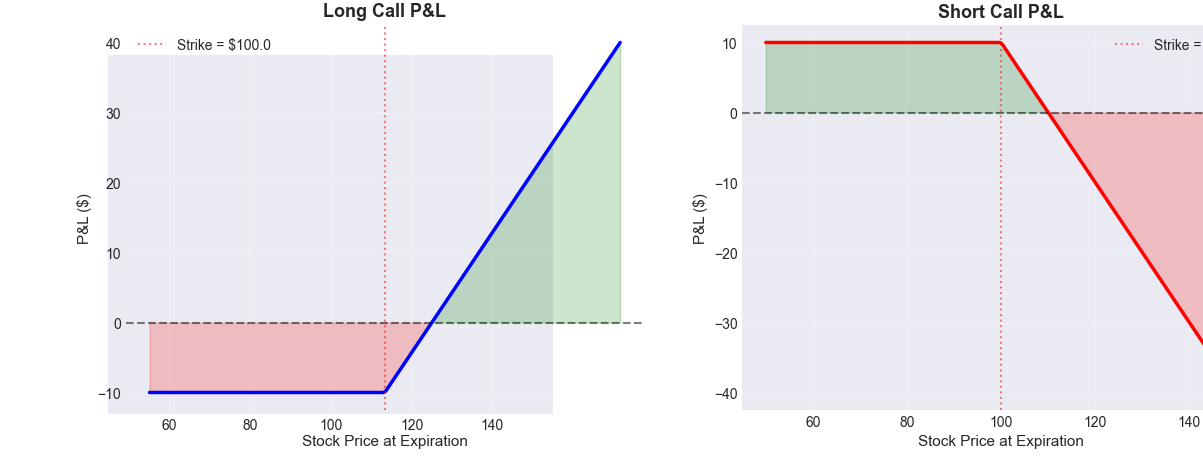

In [ ]:
# 🎛️ INTERACTIVE GREEKS CALCULATOR

@interact(
    S0=FloatSlider(value=100, min=50, max=150, step=1, description='Stock ($):'),
    K=FloatSlider(value=100, min=50, max=150, step=1, description='Strike ($):'),
    r=FloatSlider(value=0.05, min=0.0, max=0.15, step=0.01, description='Rate:'),
    sigma=FloatSlider(value=0.20, min=0.05, max=0.60, step=0.01, description='Vol (σ):'),
    T=FloatSlider(value=1.0, min=0.1, max=3.0, step=0.1, description='Time (yrs):'),
    option_type=Dropdown(options=['Call', 'Put'], value='Call', description='Option:')
)
def show_greeks(S0=100, K=100, r=0.05, sigma=0.20, T=1.0, option_type='Call'):
    """Interactive Greeks display with detailed interpretations.
    
    Greeks measure how option price changes with respect to various parameters.
    They are essential for:
    - Risk management (how much will position lose if market moves?)
    - Hedging (how many shares/options to neutralize risk?)
    - Strategy construction (understanding exposure)
    """
    if option_type == 'Call':
        greeks = bsm_call_greeks(S0, K, r, sigma, T)
        price = bsm_call_price(S0, K, r, sigma, T)
    else:
        greeks = bsm_put_greeks(S0, K, r, sigma, T)
        price = bsm_put_price(S0, K, r, sigma, T)
    
    moneyness = "ITM" if (S0 > K and option_type == 'Call') or (S0 < K and option_type == 'Put') else \
                "ATM" if abs(S0 - K) < 2 else "OTM"
    
    print("═" * 70)
    print(f"📊 {option_type.upper()} OPTION GREEKS ({moneyness})")
    print("═" * 70)
    print(f"Parameters: S=${S0:.2f}, K=${K:.2f}, r={r*100:.1f}%, σ={sigma*100:.1f}%, T={T:.2f} years")
    print("-" * 70)
    print(f"Option Price: ${price:.4f}")
    print("-" * 70)
    print(f"{'Greek':<10} {'Value':<15} {'Mathematical':<25} {'Practical Meaning'}")
    print("-" * 70)
    print(f"{'Delta':<10} {greeks['delta']:>14.4f}  ∂Price/∂S        Hedge ratio (shares per option)")
    print(f"{'Gamma':<10} {greeks['gamma']:>14.4f}  ∂²Price/∂S²     Rate of delta change (convexity)")
    print(f"{'Vega':<10} {greeks['vega']:>14.4f}  ∂Price/∂σ       Vol sensitivity (per 1% vol)")
    print(f"{'Theta':<10} {greeks['theta']:>14.4f}  ∂Price/∂T       Time decay (per year)")
    print(f"{'Rho':<10} {greeks['rho']:>14.4f}  ∂Price/∂r       Rate sensitivity (per 1%)")
    print("═" * 70)
    
    # Add practical interpretation
    print("\n💡 Practical Interpretation:")
    print(f"- If stock moves $1 → Option price changes by ${greeks['delta']:.2f}")
    print(f"- If volatility increases 1% → Option gains ${greeks['vega']:.2f}")
    print(f"- Each year passes → Option loses ${abs(greeks['theta']):.2f} (time decay)")
    if option_type == 'Call':
        print(f"- If rates rise 1% → Option gains ${greeks['rho']:.2f}")
    else:
        print(f"- If rates rise 1% → Option loses ${abs(greeks['rho']):.2f}")
    print("═" * 70)


### Interpretation:
- **Delta (call ≈ 0.56, put ≈ -0.44)**: An ATM call gains ~$0.56 for each $1 increase in stock price.
- **Gamma**: Both call and put have the same gamma, measuring convexity.
- **Vega**: Both have the same positive vega; they gain value if volatility increases.
- **Theta**: Both lose value over time (negative theta for long positions).
- **Rho**: Call benefits from higher rates, put suffers.


## 4. Greeks vs Stock Price

Let's see how Greeks change as we vary the stock price (moneyness).


In [ ]:
# 🎛️ INTERACTIVE GREEKS vs STOCK PRICE

@interact(
    K=FloatSlider(value=100, min=80, max=120, step=5, description='Strike ($):'),
    r=FloatSlider(value=0.05, min=0.0, max=0.15, step=0.01, description='Rate:'),
    sigma=FloatSlider(value=0.20, min=0.10, max=0.50, step=0.05, description='Vol (σ):'),
    T=FloatSlider(value=1.0, min=0.25, max=2.0, step=0.25, description='Time (yrs):')
)
def plot_greeks_vs_price(K=100, r=0.05, sigma=0.20, T=1.0):
    """Interactive Greeks vs Stock Price.
    
    This visualization shows how option sensitivity changes as the stock price
    moves relative to the strike (moneyness). Understanding these relationships
    is essential for risk management and strategy construction.
    """
    S_vals = np.linspace(K*0.6, K*1.4, 100)
    
    greeks_names = ['delta', 'gamma', 'vega', 'theta']
    call_greeks_vs_S = {name: [] for name in greeks_names}
    
    for S in S_vals:
        cg = bsm_call_greeks(S, K, r, sigma, T)
        for name in greeks_names:
            call_greeks_vs_S[name].append(cg[name])
    
    for name in greeks_names:
        call_greeks_vs_S[name] = np.array(call_greeks_vs_S[name])
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for i, name in enumerate(greeks_names):
        axes[i].plot(S_vals, call_greeks_vs_S[name], 'b-', linewidth=2.5)
        axes[i].axvline(x=K, color='r', linestyle='--', linewidth=2, alpha=0.6, label=f'Strike=${K}')
        axes[i].axhline(y=0, color='k', linestyle='--', alpha=0.3)
        axes[i].set_xlabel('Stock Price ($)', fontsize=11)
        axes[i].set_ylabel(name.capitalize(), fontsize=11)
        axes[i].set_title(f'{name.capitalize()} vs Stock Price', fontsize=12, fontweight='bold')
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()
        
        # Mark ATM value
        atm_idx = np.argmin(np.abs(S_vals - K))
        atm_value = call_greeks_vs_S[name][atm_idx]
        axes[i].plot(K, atm_value, 'ro', markersize=8)
        axes[i].text(K*1.02, atm_value, f'{atm_value:.3f}', fontsize=9, 
                     verticalalignment='center')
    
    plt.tight_layout()
    plt.show()
    
    # Get ATM values for interpretation
    atm_greeks = bsm_call_greeks(K, K, r, sigma, T)
    
    print("═" * 70)
    print("📊 INTERPRETATION: Greeks vs Stock Price (Moneyness)")
    print("═" * 70)
    print(f"Parameters: K=${K}, r={r*100:.1f}%, σ={sigma*100:.1f}%, T={T:.2f} years")
    print("-" * 70)
    print(f"At-the-Money Greeks (when S = K):")
    print(f"  Delta:  {atm_greeks['delta']:.4f}  → Option moves ~{atm_greeks['delta']:.1%} of stock moves")
    print(f"  Gamma:  {atm_greeks['gamma']:.4f}  → Delta changes rapidly near ATM")
    print(f"  Vega:   {atm_greeks['vega']:.4f}  → ${atm_greeks['vega']:.2f} per 1% vol change")
    print(f"  Theta:  {atm_greeks['theta']:.4f}  → ${abs(atm_greeks['theta']):.2f} per year time decay")
    print("-" * 70)
    print("Practical Implications:")
    print("- **Deep ITM (S >> K)**: Delta ≈ 1, behaves like stock, low gamma/vega")
    print("- **ATM (S ≈ K)**: Highest gamma and vega, highest time decay risk")
    print("- **Deep OTM (S << K)**: Delta ≈ 0, low value, behaves like lottery ticket")
    print("═" * 70)


interactive(children=(FloatSlider(value=100.0, description='Strike ($):', max=120.0, min=80.0, step=5.0), Floa…

In [ ]:
# 🎛️ INTERACTIVE: Greeks vs Time to Expiration (DTE)

@interact(
    S0=FloatSlider(value=100, min=80, max=120, step=5, description='Stock ($):'),
    K=FloatSlider(value=100, min=80, max=120, step=5, description='Strike ($):'),
    r=FloatSlider(value=0.05, min=0.0, max=0.15, step=0.01, description='Rate:'),
    sigma=FloatSlider(value=0.20, min=0.10, max=0.50, step=0.05, description='Vol (σ):')
)
def plot_greeks_vs_dte(S0=100, K=100, r=0.05, sigma=0.20):
    """Interactive plot of Greeks as functions of time to expiration."""
    T_grid = np.linspace(0.05, 2.0, 50)  # From 18 days to 2 years
    
    greeks_names = ['delta', 'gamma', 'vega', 'theta']
    greeks_vs_T = {name: [] for name in greeks_names}
    
    for T in T_grid:
        greeks = bsm_call_greeks(S0, K, r, sigma, T)
        for name in greeks_names:
            greeks_vs_T[name].append(greeks[name])
    
    for name in greeks_names:
        greeks_vs_T[name] = np.array(greeks_vs_T[name])
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    titles = {
        'delta': 'Delta vs Time to Expiration',
        'gamma': 'Gamma vs Time to Expiration',
        'vega': 'Vega vs Time to Expiration',
        'theta': 'Theta vs Time to Expiration'
    }
    
    for i, name in enumerate(greeks_names):
        axes[i].plot(T_grid, greeks_vs_T[name], 'b-', linewidth=2.5)
        axes[i].axhline(y=0, color='k', linestyle='--', alpha=0.3)
        axes[i].set_xlabel('Time to Expiration (years)', fontsize=11)
        axes[i].set_ylabel(name.capitalize(), fontsize=11)
        axes[i].set_title(titles[name], fontsize=12, fontweight='bold')
        axes[i].grid(True, alpha=0.3)
        
        # Mark short-term (1 month) and long-term (1 year) points
        if name == 'gamma':
            idx_short = np.argmin(np.abs(T_grid - 0.083))  # 1 month
            axes[i].plot(T_grid[idx_short], greeks_vs_T[name][idx_short], 'ro', markersize=8, label='1 month')
        
        if name == 'vega':
            idx_long = np.argmin(np.abs(T_grid - 1.0))  # 1 year
            axes[i].plot(T_grid[idx_long], greeks_vs_T[name][idx_long], 'go', markersize=8, label='1 year')
        
        if name in ['gamma', 'vega']:
            axes[i].legend()
    
    plt.tight_layout()
    plt.show()
    
    print("═" * 70)
    print("📊 INTERPRETATION: Greeks vs Time to Expiration")
    print("═" * 70)
    print(f"Current parameters: S=${S0}, K=${K}, r={r*100:.1f}%, σ={sigma*100:.1f}%")
    print("-" * 70)
    print("Key Observations:")
    print("- **Delta**: For ATM options, delta approaches 0.5 as T→0. For ITM/OTM, delta")
    print("            approaches 1 or 0 respectively. Longer-dated options have more")
    print("            gradual delta transitions.")
    print("- **Gamma**: Peaks for short-dated ATM options (high convexity near expiry).")
    print("            Longer-dated options have lower gamma (more linear behavior).")
    print("- **Vega**: Increases with time to expiration (more time = more uncertainty = higher vol sensitivity).")
    print("            Long-dated options are much more sensitive to volatility changes.")
    print("- **Theta**: Becomes more negative (greater time decay) as expiration approaches, especially for ATM.")
    print("            Time decay accelerates dramatically in the final weeks.")
    print("═" * 70)
